# Introduction


In machine learning workflows, the Pipeline class from Scikit-Learn is invaluable for streamlining data preprocessing and model training into a single, coherent sequence. A pipeline is essentially a sequence of data transformers that culminates with an optional final predictor. This structure enables seamless integration of preprocessing and predictive modeling, ensuring that the same data transformations applied during training are consistently applied to new data during prediction.

Each intermediate step in a pipeline must be a transformer, meaning it should implement both fit and transform methods. The final step, which is typically a predictive model, or estimator, only requires a fit method. The entire pipeline can be trained simultaneously using a method like GridSearchCV, resulting in self-contained predictor that can be used to make predictions on unseen data.

Importantly, the pipeline allows you to set the parameters of each of these steps using their names and parameter names connected by a double underscore `__`. For example, if a pipeline step is named `imputer` and you want to change its strategy, you can pass a parameter like `imputer__strategy='median'`. Additionally, steps can be entirely swapped out by assigning a different estimator or even bypassed by setting them to `'passthrough'` or `None`.

A major advantage of using a pipeline is that it enables comprehensive cross-validation and hyperparameter tuning for all steps simultaneously. By integrating the pipeline within GridSearchCV, you can fine-tune not only the model but also the preprocessing steps, leading to optimized overall performance. Pipelines are essential for scenarios where preprocessing involves estimators performing operations like scaling, encoding categorical variables, imputing missing values, and dimensionality reduction. Pipelines ensure these steps are reproducibly applied to both training and test data.


In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Machine Learning Pipelines and GridSearchCV

In [13]:
data = load_iris()
X, y = data.data, data.target
labels = data.target_names

# Pipeline
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=2),),
  ('knn', KNeighborsClassifier(n_neighbors=5))
])

Split the data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Fit the pipeline on the training set

The pipeline consists of a sequence of three estimators, and should be viewed as the machine learning model we are training and testing.  
Let's go ahead and fit the model to the training data and evaluate its accuracy.


In [11]:
pipeline.fit(X_train, y_train)

# Measure the pipeline accuracy on the test data
test_score = pipeline.score(X_test, y_test)
print(f"{test_score: .3f}")

# Model predictions
y_pred = pipeline.predict(X_test)

 0.933


Generate the confusion matrix for the KNN model and plot it

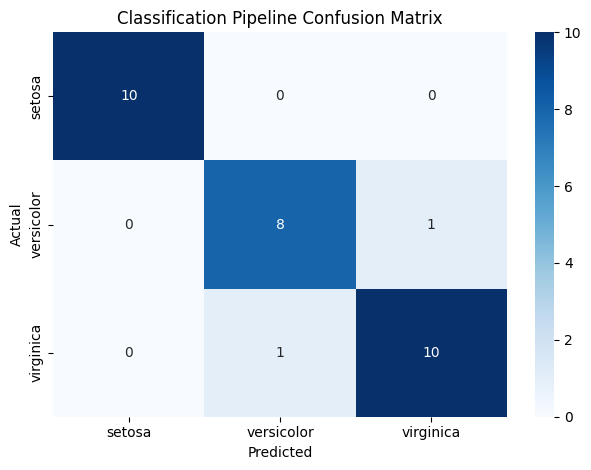

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)

plt.title('Classification Pipeline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

The model incorectly classified two viginica irises as versicolor, and one versicolor as virginica. Not bad, only three classification errors out of 30 irises on our first attempt!

**Tune hyperparameters using a pipeline within cross-validation grid search**

We created a model but haven't yet attempted to optimize its performance.  Let's see if we can do better.
Recall that it would be a mistake to keep running the model over and over again with different hyperparamters to find the best one.  
You would effectively be overfiiting the model to your test data set.  
The correct way to handle this tuning is to use cross validation. 

Let's see how it works, using the same data set.


In [26]:
# pipeline without specifying any parameters yet
pipeline = Pipeline([
  ('Scaler', StandardScaler()),
  ('pca', PCA()),
  ('knn', KNeighborsClassifier())
])

# Hyperparameter search grid for numbers of PCA components and KNN neighbors
param_grid = {
  'pca__n_components': [2, 3],
  'knn__n_neighbors': [3, 5, 7]
}

Choose a cross Validation method. To ensure the target is stratified, we can use scikit-learn's `StratifiedKFold` cross-validation class.

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
best_model = GridSearchCV(estimator=pipeline,
                          param_grid=param_grid,
                          cv=cv,
                          scoring='accuracy',
                          verbose=2
                        )

best_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_c

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__n_neighbors': [3, 5, ...], 'pca__n_components': [2, 3]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [33]:
test_score = best_model.score(X_test, y_test)
print(f"{test_score:.3f}")
best_model.best_params_

1.000


{'knn__n_neighbors': 7, 'pca__n_components': 3}

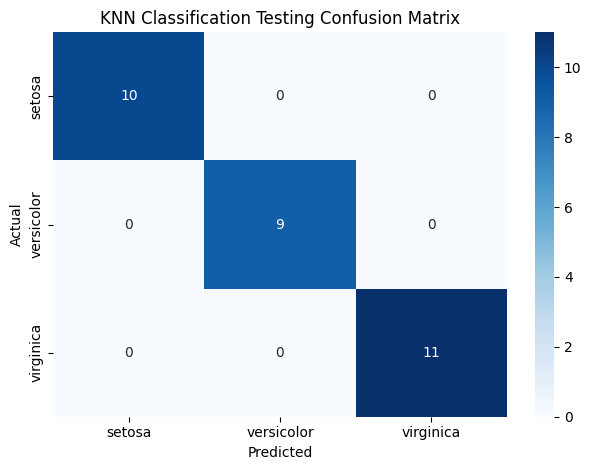

In [34]:
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)

plt.title('KNN Classification Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()